# Text CNN

## 网络定义

网络结构如下图：
![TextCNN architecture](images/textcnn_architecture.png)

网络细节：
![TextCNN](images/text_cnn.png)

## 数据

In [14]:
from tensorflow import keras

num_features = 3000

(x_train, y_train), (x_test, y_test) = keras.datasets.imdb.load_data(num_words=num_features)
print(x_train.shape)
print(x_test.shape)
print(y_train.shape)
print(y_test.shape)

(25000,)
(25000,)
(25000,)
(25000,)


In [15]:
from tensorflow.keras.preprocessing.sequence import pad_sequences

sequence_length = 300

x_train = pad_sequences(x_train, maxlen=sequence_length)
x_test = pad_sequences(x_test, maxlen=sequence_length)
print(x_train.shape)
print(x_test.shape)
print(y_train.shape)
print(y_test.shape)

(25000, 300)
(25000, 300)
(25000,)
(25000,)


In [25]:
from tensorflow import keras
from tensorflow.keras import layers
from tensorflow.keras import backend as K

num_features = 3000
sequence_length = 300
embedding_dimension = 100

filter_sizes=[3,4,5]


def precision(y_true, y_pred):
    # Calculates the precision
    true_positives = K.sum(K.round(K.clip(y_true * y_pred, 0, 1)))
    predicted_positives = K.sum(K.round(K.clip(y_pred, 0, 1)))
    precision = true_positives / (predicted_positives + K.epsilon())
    return precision


def recall(y_true, y_pred):
    # Calculates the recall
    true_positives = K.sum(K.round(K.clip(y_true * y_pred, 0, 1)))
    possible_positives = K.sum(K.round(K.clip(y_true, 0, 1)))
    recall = true_positives / (possible_positives + K.epsilon())
    return recall

def fbeta_score(y_true, y_pred, beta=1):
    # Calculates the F score, the weighted harmonic mean of precision and recall.

    if beta < 0:
        raise ValueError('The lowest choosable beta is zero (only precision).')
        
    # If there are no true positives, fix the F score at 0 like sklearn.
    if K.sum(K.round(K.clip(y_true, 0, 1))) == 0:
        return 0

    p = precision(y_true, y_pred)
    r = recall(y_true, y_pred)
    bb = beta ** 2
    fbeta_score = (1 + bb) * (p * r) / (bb * p + r + K.epsilon())
    return fbeta_score

def fmeasure(y_true, y_pred):
    # Calculates the f-measure, the harmonic mean of precision and recall.
    return fbeta_score(y_true, y_pred, beta=1)

def convolution():
    inn = layers.Input(shape=(sequence_length, embedding_dimension, 1))
    cnns = []
    for size in filter_sizes:
        conv = layers.Conv2D(filters=64, kernel_size=(size, embedding_dimension),
                            strides=1, padding='valid', activation='relu')(inn)
        pool = layers.MaxPool2D(pool_size=(sequence_length-size+1, 1), padding='valid')(conv)
        cnns.append(pool)
    outt = layers.concatenate(cnns)
    
    model = keras.Model(inputs=inn, outputs=outt)
    
    return model

def cnn_mulfilter():
    model = keras.Sequential([
        layers.Embedding(input_dim=num_features, output_dim=embedding_dimension,
                        input_length=sequence_length),
        layers.Reshape((sequence_length, embedding_dimension, 1)),
        convolution(),
        layers.Flatten(),
        layers.Dense(10, activation='relu'),
        layers.Dropout(0.2),
        layers.Dense(1, activation='sigmoid')
        
    ])
    
    model.compile(optimizer=keras.optimizers.Adam(),
                 loss=keras.losses.BinaryCrossentropy(),
                 metrics=['accuracy', precision, recall, fmeasure])
    
    return model

In [26]:
model = cnn_mulfilter()
model.summary()

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
embedding_5 (Embedding)      (None, 300, 100)          300000    
_________________________________________________________________
reshape_2 (Reshape)          (None, 300, 100, 1)       0         
_________________________________________________________________
model_5 (Model)              (None, 1, 1, 192)         76992     
_________________________________________________________________
flatten_5 (Flatten)          (None, 192)               0         
_________________________________________________________________
dense_7 (Dense)              (None, 10)                1930      
_________________________________________________________________
dropout_2 (Dropout)          (None, 10)                0         
_________________________________________________________________
dense_8 (Dense)              (None, 1)                 11        
Total para

In [27]:
%%time
history = model.fit(x_train, y_train, batch_size=64, epochs=5, validation_split=0.1)

Train on 22500 samples, validate on 2500 samples
Epoch 1/5
22500/22500 [==============================] - 91s 4ms/sample - loss: 0.4759 - acc: 0.7517 - precision: 0.7494 - recall: 0.6967 - fmeasure: 0.6917 - val_loss: 0.3308 - val_acc: 0.8664 - val_precision: 0.8631 - val_recall: 0.8118 - val_fmeasure: 0.8346
Epoch 2/5
22500/22500 [==============================] - 89s 4ms/sample - loss: 0.2808 - acc: 0.8901 - precision: 0.8908 - recall: 0.8930 - fmeasure: 0.8894 - val_loss: 0.2861 - val_acc: 0.8876 - val_precision: 0.8827 - val_recall: 0.8956 - val_fmeasure: 0.8874
Epoch 3/5
22500/22500 [==============================] - 95s 4ms/sample - loss: 0.2016 - acc: 0.9294 - precision: 0.9273 - recall: 0.9329 - fmeasure: 0.9288 - val_loss: 0.2807 - val_acc: 0.8940 - val_precision: 0.8985 - val_recall: 0.8894 - val_fmeasure: 0.8918
Epoch 4/5
22500/22500 [==============================] - 112s 5ms/sample - loss: 0.1448 - acc: 0.9546 - precision: 0.9534 - recall: 0.9568 - fmeasure: 0.9541 - val_l

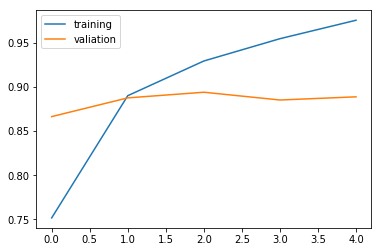

In [31]:
import matplotlib.pyplot as plt

plt.plot(history.history['acc'])
plt.plot(history.history['val_acc'])
plt.legend(['training', 'valiation'], loc='upper left')
plt.show()

In [28]:
model.evaluate(x_test, y_test, batch_size=64)

25000/25000 [==============================] - 24s 979us/sample - loss: 0.3295 - acc: 0.8822 - precision: 0.8648 - recall: 0.9054 - fmeasure: 0.8830


[0.32945645018577574, 0.8822, 0.8647925, 0.9054378, 0.8829942]